# Movie Recommendation Pipeline with Diversification

This notebook is a simple demo for our paper "Diversified recommendations of cultural activities with personalized determinantal point processes". 

The pass Culture recommender pipeline with the DPP sampler is described in Figure 1: 
![alt text](images/pipeline_diagram.png "Figure 1: pass Culture recommender system pipeline")

This notebook replicates the Two tower retreival model, the semantic embeddings with all-mini-L6-v2 and the DPP filter without the final ranking stage. The main goal of this notebook is to:
- Serve as a simple demo for our paper
- Give practioners a ready-to-use implementation of the DPP architecture in recommenders systems
- Show the effect of DPP filtering on diversity of recommendations

## Dataset:
The original data at pass Culture contains items and the description of the items (for example: a movie and the plot of the movie, or a book and the description of the book). These descriptions are used to generate semantic embedding for the items. To mimic the pass Culture data, we use the movieLens dataset in this notebook. To get "item descriptions", we use [`vishnupriyavr/wiki-movie-plots-with-summaries`]( https://huggingface.co/datasets/vishnupriyavr/wiki-movie-plots-with-summaries) dataset to get movies plots which will be later embedded by [`all-mini-l6-v2`](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2). 923 movies are kept after filtering.

## Steps covered in this notebook
### "Offline" steps:
- Load and preprocess movieLens movies and ratings data only keeping those that have a plot summary in the wiki-movie-plots-with-summaries dataset.
- Compute semantic embeddings of movies plots with `all-mini-l6-v2` model.
- Train a two-tower retrieval model following the tensorflow recommenders [tutoriel](https://www.tensorflow.org/recommenders/examples/basic_retrieval)
- Build a vector database to store movies two-tower embeddings, used later for retrieval.

### Online steps:
- Create the DPP module through `DiversificationPipeline` class
- Benchmark retrieval vs retrieval + DPP:
    - For one user, retrieve 100 movies with the Two Tower retrieval model 
    - Get the top 10 recommendations with highest cosine similarity with the user (TT-reco)
    - Sample 10 diversified movies from the 100 retrieved recommendations. (TT+DPP-reco)
    - Plot the two sets of recommendations in a 2D plot by projecting the item embeddings with a t-SNE.
    - Compute diversity and relevance metrics : 
        - Diversity Metrics:
            - The volume of the recommended items is a measure of diversification. It is computed as the square root of the determinant of the matrix containing semantic embeddings of the items. The bigger the volume, the more diversified the set of items is.
            - The business diversity metric defined as follows: each recommendation is assigned a score based on its novelty relative to the user's historical interactions, with a maximum score of 6.5 (2.5 points for a new category, 2 points for a new venue type, 1 point for a new subcategory, and 0.5 points for a new venue or genre). It quantifies the user's increase in coverage of the catalog.
        - Relevance metrics:
            - the cosine similarity between user two-tower embedding and item two-tower embedding. 
            - Note: In the paper, we also computed the click rate of our users during the online A/B/C test as a relevance metric but in this demo we obviously cannot calculate it. 


In [21]:
## imports
from typing import Dict, Text, List

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_recommenders as tfrs

from sentence_transformers import SentenceTransformer

from dppy.finite_dpps import FiniteDPP

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
import os
import random

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Offline steps:
1. Step 1: load and preprocess movieLens data 
2. Step 2: compute semantic embeddings of movies plot summaries
3. Step 3: Build and train the two tower model
4. Step 4: Build a vector database containing the movies two-tower embeddings 

## Step 1: load and preprocess movieLens data 
- only keep movies which have a plot summary in the HF dataset
- create a train dataset with 50k samples and a test set with about 17k samples.

In [22]:
# Load the movie plots dataset from HuggingFace 
df_movies_plots = pd.read_csv(
    "hf://datasets/vishnupriyavr/wiki-movie-plots-with-summaries/wiki_movie_plots_deduped_with_summaries.csv"
)[['Title', 'PlotSummary']]

df_movies_plots.drop_duplicates(subset=['Title'], keep='last', inplace=True)

download_config = tfds.download.DownloadConfig(verify_ssl = False)

## Load movies and ratings dataset from TFRS
ratings = tfds.load("movielens/100k-ratings", split="train", download_and_prepare_kwargs={'download_config': download_config})
movies = tfds.load("movielens/100k-movies", split="train", download_and_prepare_kwargs={'download_config': download_config})


## Filter movies and ratings dataset to keep those with plots
ratings_list = list(ratings)  # Will work for 100k dataset
ratings_dicts = [
    {
        "user_id": x["user_id"].numpy().decode("utf-8"),
        "movie_title": x["movie_title"].numpy().decode("utf-8"),
    }
    for x in ratings_list
]
ratings_df = pd.DataFrame(ratings_dicts)
ratings_df.movie_title = ratings_df.movie_title.map(lambda x: x.split('(')[0].strip())
ratings_df = pd.merge(ratings_df, df_movies_plots, left_on='movie_title', right_on='Title', how='inner')[['user_id', 'movie_title']]
ratings_ds = tf.data.Dataset.from_tensor_slices(dict(ratings_df))

## Filter movies dataset
movies_list = list(movies)  
movies_dicts = [
    {
        "movie_title": x["movie_title"].numpy().decode("utf-8"),
    }
    for x in movies_list
]
movies_df = pd.DataFrame(movies_dicts)
movies_df.movie_title = movies_df.movie_title.map(lambda x: x.split('(')[0].strip())
movies_df = pd.merge(movies_df, df_movies_plots, left_on='movie_title', right_on='Title', how='inner')[['movie_title']]
movies_ds = tf.data.Dataset.from_tensor_slices(dict(movies_df))


# Prepare the ratings dataset for training
ratings_ds = ratings_ds.map(lambda x: {
    "movie_title": x["movie_title"],
    "user_id": x["user_id"],
})
movies_ds = movies_ds.map(lambda x: x["movie_title"])


# Shuffle and split the data
tf.random.set_seed(42)
shuffled = ratings_ds.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(50_000) ## After filtering rating_ds has 67,921 rows
test = shuffled.skip(50_000).take(20_000)

# Prepare unique user and movie vocabularies
movie_titles = movies_ds.batch(1_000)
user_ids = ratings_ds.batch(1_000_000).map(lambda x: x["user_id"])
unique_movie_titles = np.unique(np.concatenate(list(movie_titles)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

# Filter the df_movies_plots dataframe to keep only movies that exist in movielens
df_movies_plots = df_movies_plots[df_movies_plots.Title.isin([str(movie_name.decode("utf-8")) for movie_name in unique_movie_titles])]


## Step 2: compute semantic embeddings of movies plot summaries


In [35]:
## Add the semantic embeddings to the df_movies_plots 

# Load the model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Compute embeddings
df_movies_plots['plot_semantic_embedding'] = df_movies_plots['PlotSummary'].apply(lambda x: embedding_model.encode(x, convert_to_numpy=True))


## Step 3: Build and train the two tower model

In [23]:
## Define the Two Tower model 
embedding_dimension = 32

user_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_user_ids, mask_token=None),
  # We add an additional embedding to account for unknown tokens.
  tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension),
  tf.keras.layers.UnitNormalization(axis=-1, name="l2_normalize")
])

movie_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_movie_titles, mask_token=None),
  tf.keras.layers.Embedding(len(unique_movie_titles) + 1, embedding_dimension),
  tf.keras.layers.UnitNormalization(axis=-1, name="l2_normalize")
])

metrics = tfrs.metrics.FactorizedTopK(
  candidates=movies_ds.batch(128).map(movie_model)
)
task = tfrs.tasks.Retrieval(
  metrics=metrics
)

class MovielensModel(tfrs.Model):
  def __init__(self, user_model, movie_model):
    super().__init__()
    self.movie_model: tf.keras.Model = movie_model
    self.user_model: tf.keras.Model = user_model
    self.task: tf.keras.layers.Layer = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["user_id"])
    # And pick out the movie features and pass them into the movie model,
    # getting embeddings back.
    positive_movie_embeddings = self.movie_model(features["movie_title"])

    # The task computes the loss and the metrics.
    return self.task(user_embeddings, positive_movie_embeddings)
  
print(f"Length train set: {len(train)},\nLength test set: {len(test)}")

Length train set: 50000,
Length test set: 17921


In [24]:
%%time
## Train the model
model = MovielensModel(user_model, movie_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

cached_train = train.shuffle(100_000, seed=42).batch(8192).cache()
cached_test = test.batch(4096).cache()

model.fit(cached_train, epochs=10)

model.evaluate(cached_test, return_dict=True)

Epoch 1/10
7/7 [==============================] - 2s 264ms/step - factorized_top_k/top_1_categorical_accuracy: 6.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0049 - factorized_top_k/top_10_categorical_accuracy: 0.0096 - factorized_top_k/top_50_categorical_accuracy: 0.0545 - factorized_top_k/top_100_categorical_accuracy: 0.1109 - loss: 56847.2156 - regularization_loss: 0.0000e+00 - total_loss: 56847.2156
Epoch 2/10
7/7 [==============================] - 2s 227ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0043 - factorized_top_k/top_5_categorical_accuracy: 0.0291 - factorized_top_k/top_10_categorical_accuracy: 0.0571 - factorized_top_k/top_50_categorical_accuracy: 0.2135 - factorized_top_k/top_100_categorical_accuracy: 0.3441 - loss: 55744.7563 - regularization_loss: 0.0000e+00 - total_loss: 55744.7563
Epoch 3/10
7/7 [==============================] - 2s 251ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0062 - factorized_top_k/top_5_categorical_accuracy:

{'factorized_top_k/top_1_categorical_accuracy': 0.00217621773481369,
 'factorized_top_k/top_5_categorical_accuracy': 0.016795936971902847,
 'factorized_top_k/top_10_categorical_accuracy': 0.03671669960021973,
 'factorized_top_k/top_50_categorical_accuracy': 0.18140728771686554,
 'factorized_top_k/top_100_categorical_accuracy': 0.32620948553085327,
 'loss': 10892.6396484375,
 'regularization_loss': 0,
 'total_loss': 10892.6396484375}

In [25]:
user_embeds = model.user_model(tf.constant(["189"]))
item_embeds = next(movies_ds.batch(1000).map(model.movie_model).as_numpy_iterator())
(user_embeds @ item_embeds.T).shape

TensorShape([1, 939])

In [26]:
pred = (user_embeds @ item_embeds.T)
preds = pred.numpy()
preds.sort(axis=1)
preds[:, -10:][:, ::-1]

array([[0.91897935, 0.88293535, 0.8802029 , 0.8769908 , 0.8674989 ,
        0.8650286 , 0.8634217 , 0.8597163 , 0.8566981 , 0.8446093 ]],
      dtype=float32)

In [27]:
# verify that user and movie two-tower embeddings are normalized
np.linalg.norm(model.user_model(unique_user_ids)[0]),  np.linalg.norm(model.movie_model(unique_movie_titles)[0])

(1.0, 0.99999994)

## Step 4: Build a vector database containing the movies two-tower embeddings 
The vector database is built with lancedb and servers to retrieve closest movies to a user given the user two tower embedding.

In [28]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model, k=100)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((movies_ds.batch(1000), movies_ds.batch(1000).map(model.movie_model)))
)
df_movies_plots

# Get recommendations.
user_id="14"
scores, titles = index(tf.constant([user_id] * 100))  # Get top 100 movies for user_id

# Display first 10 movie recommendation
displayed = '\n'.join([title.decode("utf-8") +",  "+str(score) for title, score in zip(titles[0, :10].numpy() , scores[0, :10].numpy())])
print(f"Top 10 recommendations for user {user_id}: \n\nMovie name, score: \n{displayed}")

Top 10 recommendations for user 14: 

Movie name, score: 
Big Night,  0.8341492
Mighty Aphrodite,  0.73568815
Lone Star,  0.7333306
Fargo,  0.7307024
Secrets & Lies,  0.7214512
Breaking the Waves,  0.6991305
Withnail and I,  0.6656347
Sense and Sensibility,  0.66275907
Annie Hall,  0.641955
Richard III,  0.63815695


In [29]:
index.variables[2]

<tf.Variable 'candidates:0' shape=(939, 32) dtype=float32, numpy=
array([[ 0.04544711,  0.28784332,  0.16655965, ..., -0.19696894,
        -0.12018612, -0.26273096],
       [-0.18914753,  0.00293339, -0.03486469, ..., -0.24234803,
         0.10984291,  0.00659631],
       [ 0.14664713,  0.09501591,  0.04913579, ...,  0.19017462,
        -0.1744158 , -0.05574868],
       ...,
       [ 0.01748728,  0.339592  ,  0.19120698, ...,  0.03494373,
        -0.1006736 , -0.10636622],
       [ 0.01607035,  0.14412378, -0.00688511, ..., -0.20487016,
         0.1468877 , -0.11188289],
       [-0.12066887,  0.25480038,  0.06272226, ..., -0.21847253,
        -0.1133001 , -0.2710535 ]], dtype=float32)>

# Online steps: 
1. Step 5: build DPP module
2. Step 6: Get/Predict top and diversified recommentions for a given user
3. Step 7: Apply a PCA to visualize recommendations in 2D
4. Step 8: Get/Predict top and diversified recommentions for a given user without quality score

## Step 5: build DPP module

In [31]:
class DiversificationPipeline:
    def __init__(self, item_semantic_embeddings: List, ids: List, scores: List, _lambda=1) -> None:
        self.item_semantic_embeddings = np.array(
            item_semantic_embeddings, dtype=np.float64
        )
        self.item_ids = ids
        self.scores = np.array(scores, dtype=np.float64) ## scores are relevance qi score from TT
        self._lambda = _lambda

    @staticmethod
    def _get_dpp_samples(vectors: np.ndarray, K_DPP: int) -> List:
        diversification_matrix = vectors.dot(vectors.T)
        dpp_model = FiniteDPP("likelihood", **{"L": diversification_matrix})
        return dpp_model.sample_exact_k_dpp(size=K_DPP, random_state=42)

    def get_sampled_ids(self, K_DPP: int) -> List:
        # Calculate weighted embeddings and normalize in a single step
        # return sampled item ids list and the list of relevance scores of the sampled items
        weighted_embeddings = (
            (self.scores[:, np.newaxis] ** self._lambda) * self.item_semantic_embeddings
        )

        # Apply DPP sampling
        sampled_indices = self._get_dpp_samples(
            vectors=weighted_embeddings, K_DPP=K_DPP
        )

        return [self.item_ids[i] for i in sampled_indices], [self.scores[i] for i in sampled_indices]

## Step 6: Get/Predict top and diversified recommendations for a given user

In [32]:

def get_ordered_semantic_embedding(movie_names):
    """
    Returns numpy array of the semantic embeddings of the movies names given in argument. It preserves the same order as the order of the argument
    """
    return np.array([
                    df_movies_plots.loc[df_movies_plots['Title'] == title.decode("utf-8"), 'plot_semantic_embedding'].values[0]
                    for title in movie_names
                ])
    
def retrieval(k, user_ids, user_embedding_dict, _lambda=1):
    """
    This function:
    - retrieves 100 items from two tower model for each user 
    - For each user:
        - get semantic embedding of it s top-100 retrieved items 
        - Samples 10 diversified items among the 100 retrieved using DPP sampler
    
    --Arguments--
        k: number of items to be retrieved from the DPP model
        user_ids: list of user ids 
        user_embedding_dict: dictionnary with {user_id: two tower user embedding}
        _lambda = 1 : the lambda parameter which powers the relevance quality score in the DPP kernel
    
    --Returns--
        movies_names_top_k[:, :k].numpy() : top k movies names retrieved from two tower model
        quality_scores_top_k[:, :k].numpy() : quality scores of the top k movies retrieved from two tower model
        np.row_stack(all_results_k_diversified) : top k movies names sampled with DPP
        np.row_stack(all_scores_div) : quality scores of the top k movies sampled with DPP
    """
    
    # Search for top 100 most similar movies using cosine similarity
    # the movies dataset contains 923 so we set the retrieval to 100 so its an upper bound for all results
    quality_scores_top_k, movies_names_top_k = index(tf.constant(user_ids), k=100) # retrieve 100 items for each user in user_id
    
    
    all_results_k_dpp, all_scores_dpp = [], []
    for i in range(len(user_ids)):
        
        ordered_semantic_embeddings = get_ordered_semantic_embedding(movies_names_top_k[i].numpy())
                                    
        results_k_dpp, scores_dpp = DiversificationPipeline(
                                                item_semantic_embeddings=ordered_semantic_embeddings,
                                                ids=movies_names_top_k[i].numpy(),
                                                scores=quality_scores_top_k[i].numpy(),
                                                _lambda=_lambda
                                            ).get_sampled_ids(K_DPP=k)
        all_results_k_dpp.append(results_k_dpp)
        all_scores_dpp.append(scores_dpp)
    return movies_names_top_k[:, :k].numpy(), quality_scores_top_k[:, :k].numpy(), np.row_stack(all_results_k_dpp), np.row_stack(all_scores_dpp)

In [36]:
users_list = user_model.layers[0].get_vocabulary()
users_weights = user_model.layers[1].get_weights()[0].astype(np.float32)
user_embedding_dict = {x: y for x, y in zip(users_list, users_weights)}
user_ids = np.random.choice(users_list, 100) # sample 100 random users


results_top_k, scores_top_k, results_k_dpp_lambda_1, scores_dpp_lambda_1 =  retrieval(15, user_ids, user_embedding_dict, _lambda=1)
results_top_k, scores_top_k, results_k_dpp_lambda_0, scores_dpp_lambda_0 =  retrieval(15, user_ids, user_embedding_dict, _lambda=0)

# Compute volumes
X_top_k = np.stack([get_ordered_semantic_embedding(results_top_k[i]) for i in range(results_top_k.shape[0])])
volume_top_k = np.nan_to_num(np.linalg.det(X_top_k @ np.transpose(X_top_k, (0, 2, 1))) ** 0.5, 0.).mean()

X_dpp_lambda_1 = np.stack([get_ordered_semantic_embedding(results_k_dpp_lambda_1[i]) for i in range(results_k_dpp_lambda_1.shape[0])])
volume_dpp_lambda_1 = np.nan_to_num(np.linalg.det(X_dpp_lambda_1 @ np.transpose(X_dpp_lambda_1, (0, 2, 1))) ** 0.5, 0.).mean()

X_dpp_lambda_0 = np.stack([get_ordered_semantic_embedding(results_k_dpp_lambda_0[i]) for i in range(results_k_dpp_lambda_0.shape[0])])
volume_dpp_lambda_0 = np.nan_to_num(np.linalg.det(X_dpp_lambda_0 @ np.transpose(X_dpp_lambda_0, (0, 2, 1))) ** 0.5, 0.).mean()

# put metrics in a dataframe 
displayed_results = pd.DataFrame()
displayed_results.loc['Model A (top K)', 'Relevance'] = scores_top_k.mean()
displayed_results.loc['Model B (dpp lambda=1)', 'Relevance'] = scores_dpp_lambda_1.mean()
displayed_results.loc['Model C (dpp lambda=0)', 'Relevance'] = scores_dpp_lambda_0.mean()

displayed_results.loc['Model A (top K)', 'Volume'] = volume_top_k
displayed_results.loc['Model B (dpp lambda=1)', 'Volume'] = volume_dpp_lambda_1
displayed_results.loc['Model C (dpp lambda=0)', 'Volume'] = volume_dpp_lambda_0

displayed_results.loc['Model A (top K)', 'Volume Ratio'] = volume_top_k / volume_top_k
displayed_results.loc['Model B (dpp lambda=1)', 'Volume Ratio'] = volume_dpp_lambda_1 / volume_top_k
displayed_results.loc['Model C (dpp lambda=0)', 'Volume Ratio'] = volume_dpp_lambda_0 / volume_top_k

display(displayed_results)

/var/folders/dw/nz0r7_t973z5_j607rfp9cvh0000gp/T/ipykernel_96637/575293976.py:12: RuntimeWarning: invalid value encountered in sqrt
  volume_top_k = np.nan_to_num(np.linalg.det(X_top_k @ np.transpose(X_top_k, (0, 2, 1))) ** 0.5, 0.).mean()
/var/folders/dw/nz0r7_t973z5_j607rfp9cvh0000gp/T/ipykernel_96637/575293976.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.750555366118749' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  displayed_results.loc['Model B (dpp lambda=1)', 'Relevance'] = scores_dpp_lambda_1.mean()


,Relevance,Volume,Volume Ratio
Model A (top K),0.843445,0.238565,1.000000
Model B (dpp lambda=1),0.750555,0.325787,1.365610
Model C (dpp lambda=0),0.732137,0.328467,1.376842


In [37]:
# Volume of all items in the semantic space
A = np.array(df_movies_plots.plot_semantic_embedding.tolist())
np.nan_to_num(np.linalg.det(A @ np.transpose(A)) ** 0.5, 0.).mean()

0.0

In [38]:
from tqdm import tqdm

for LAMBDA in tqdm(np.linspace(0, 2, 10)):
    MODEL_NAME = f'Model ($\lambda = {LAMBDA}$)'
    
    results_top_k, scores_top_k, results_k_diversified, scores_div =  retrieval(15, user_ids, user_embedding_dict, _lambda=LAMBDA)
    if LAMBDA == 0.:
        results_k_diversified_no_qi, scores_div_no_qi = results_k_diversified, scores_div
    displayed_results.loc[MODEL_NAME, 'Relevance'] = scores_div.mean()
    
    X_diversified = model.movie_model(results_k_diversified).numpy()
    volume_diversified = np.nan_to_num((np.linalg.det(X_diversified @ np.transpose(X_diversified, (0, 2, 1))) ** 0.5), 0.).mean()
    displayed_results.loc[MODEL_NAME, 'Volume'] = volume_diversified

100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


In [ ]:
displayed_results



,Relevance,Volume,Volume Ratio
Model A (top K),0.819250,0.218687,1.000000
Model B (dpp lambda=1),0.724529,0.320132,1.463881
Model C (dpp lambda=0),0.703347,0.321910,1.472012


: 

For recall, $\lambda = 0$ corresponds to all $q_i = 1$, while $\lambda = 1$ corresponds to personalized $q_i$ using relevance.

<Axes: xlabel='Volume', ylabel='Relevance'>

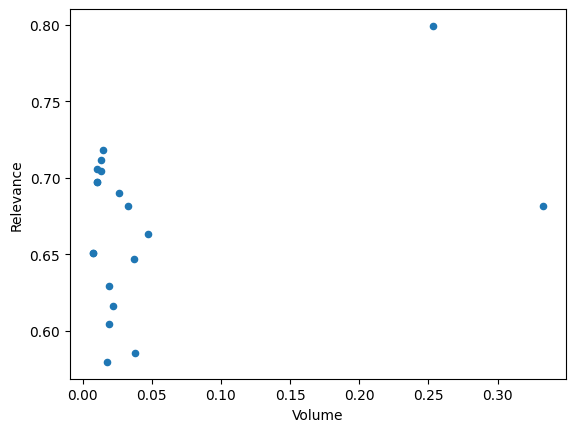

In [309]:
displayed_results.plot.scatter(x='Volume', y='Relevance')

## Step 7: Apply a T-SNE to visualize recommendations in 2D

In [310]:
%%time
from sklearn.manifold import TSNE

# Apply a tSNE on all semantic embeddings
movies_names_list = df_movies_plots['Title'].to_list()
movies_plots_list = df_movies_plots['plot_semantic_embedding'].to_list()
X = np.array(movies_plots_list)
tsne = TSNE(n_components=2)
X_2d = tsne.fit_transform(X)

CPU times: user 12.8 s, sys: 3.07 s, total: 15.9 s
Wall time: 2.23 s


In [311]:
def plot_two_sets_of_recos(results_top_k, results_k_diversified, results_k_diversified_no_qi, X_2d):
    plt.figure(figsize=(8, 6))

    # Plot top_k recommendations
    # TODO factor this
    top_k_movies_indices = [movies_names_list.index(movie_name.decode('utf-8')) for movie_name in results_top_k]
    print(top_k_movies_indices)
    plt.scatter([X_2d[i, 0] for i in top_k_movies_indices],
                [X_2d[i, 1] for i in top_k_movies_indices], 
                color='red', label="top $k$ recommendations", marker='.', s=200)
    for movie_id, name in zip(top_k_movies_indices, results_top_k):
        plt.annotate(name.decode('utf-8'), xy=X_2d[movie_id], xytext=X_2d[movie_id] + 0.02, c='red')

    # Plot diversified recommendations
    diversified_k_movies_indices = [movies_names_list.index(movie_name.decode('utf-8')) for movie_name in results_k_diversified]
    plt.scatter([X_2d[i, 0] for i in diversified_k_movies_indices],
                [X_2d[i, 1] for i in diversified_k_movies_indices], 
                color='blue', label="diversified $\lambda = 3$ recommendations", marker='.', s=200)

    # Plot diversified recommendations no q_i
    diversified_no_qi_k_movies_indices = [movies_names_list.index(movie_name.decode('utf-8')) for movie_name in results_k_diversified_no_qi]
    plt.scatter([X_2d[i, 0] for i in diversified_no_qi_k_movies_indices],
                [X_2d[i, 1] for i in diversified_no_qi_k_movies_indices], 
                color='forestgreen', label="diversified $\lambda = 0$ recommendations", marker='.', s=200)


    plt.title("Movie Embeddings ($t$-SNE 2D)")
    plt.xlabel("$t$-SNE axis 1")
    plt.ylabel("$t$-SNE axis 2")
    plt.legend()
    plt.grid(True)
    plt.show()


[138, 139, 224, 182, 125, 184, 413, 102, 334, 195, 790, 163, 343, 157, 841]


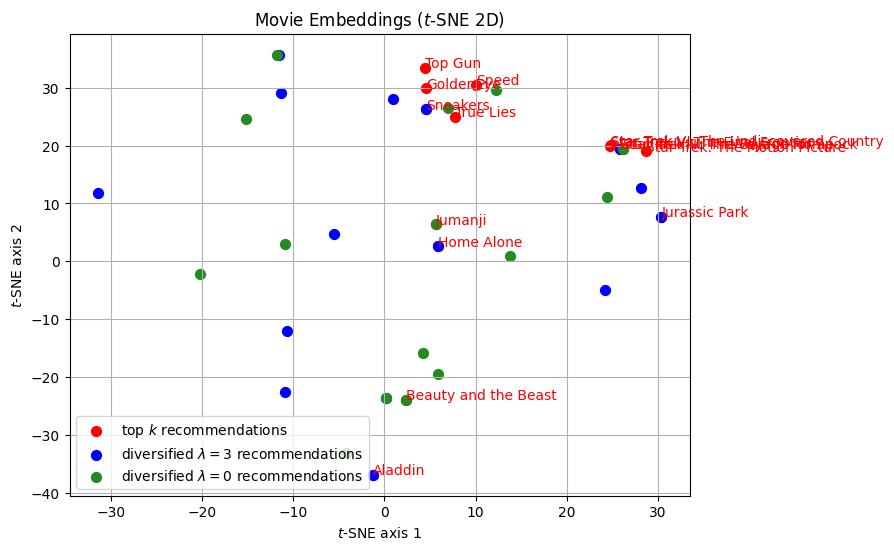

In [312]:
plot_two_sets_of_recos(results_top_k[0], results_k_diversified[0], results_k_diversified_no_qi[0], X_2d)

In [313]:
displayed_results['Volume ratio'] = displayed_results['Volume'] / volume_top_k

In [314]:
displayed_results

,Relevance,Volume,Volume ratio
Model A (top K),0.799136,0.253357,1.000000
Model B (dpp lambda=1),0.681583,0.333154,1.314959
Model ($\lambda = 0.0$),0.647155,0.036879,0.145563
Model ($\lambda = 0.3333333333333333$),0.650608,0.007239,0.028574
Model ($\lambda = 0.6666666666666666$),0.663074,0.047031,0.185630
Model ($\lambda = 1.0$),0.681583,0.032922,0.129942
Model ($\lambda = 1.3333333333333333$),0.690255,0.026401,0.104206
Model ($\lambda = 1.6666666666666665$),0.697117,0.010455,0.041266
Model ($\lambda = 2.0$),0.705926,0.010711,0.042275
Model ($\lambda = 2.333333333333333$),0.704601,0.013470,0.053165


<Axes: xlabel='Volume ratio', ylabel='Relevance'>

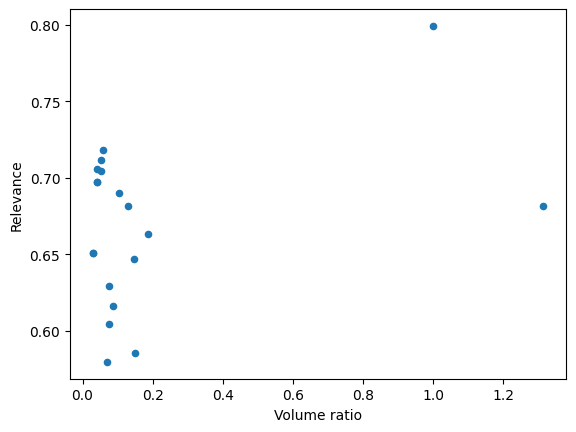

In [315]:
displayed_results.plot.scatter(x='Volume ratio', y='Relevance')

# Remarks: 
- The two tower retrieval model is a dummy model. It does not necessarily perform well especially considering the 'factorized_top_k/top_*_categorical_accuracy'. This means that even the top-10 closest movies can be already diverse.
- With our data at pass culture, we observe a high impact of DPP sampling on diversity metrics. We typically have a factor of 12x or 15x gain in volume after samping with DPPs. Our business diversification metric also increased by at least 12%.
